# Image Segmentation on Oxford-pets Dataset. 

## Importing Libraries

In [1]:
import os
# training on CPU 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow_datasets as tfds 
print(tf.__version__)

2.5.0


## Downloading Oxford-IIIT Pets Dataset.

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

## Exploring the dataset.

In [3]:
dataset.keys()

dict_keys(['train', 'test'])

In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\User\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    

## Preparing the datasets.

## Helper function 1, 2:

These two helper functions will randomly flip the images and then noralaize it. Which is necessary for removing bias.

In [5]:
def random_flip(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask
def normalize(input_image, input_mask):
    # normalizes the image to be in range [0, 1]
    input_image = tf.cast(input_image, tf.float32) / 255.0 
    # normalizes the mask to be in range [0, 2]
    input_mask -= 1
    return input_image, input_mask

## Helper function 3, 4:
#### These two helper functions will be mapping function for the train and testing dataset.

In [6]:
@tf.function
def load_train_image(dataset):
    input_image = tf.image.resize(images=dataset['image'], size=(128,128), method='nearest')
    input_mask = tf.image.resize(images=dataset['segmentation_mask'], size=(128, 128), method='nearest')
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_test_image(dataset):
    input_image = tf.image.resize(images=dataset['image'], size=(128,128),  method='nearest')
    input_mask = tf.image.resize(images=dataset['segmentation_mask'], size=(128,128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

####  Now we perform the preprocessing of training and test set.
Train Dataset : 
- We first load the images using the mapping function.
- Now, using those images, we will create dataaset. 
- Next we shuffle them with the buffer size.
- Then we create batches of the Train Dataset.
- Repeating the dataset so each original value is seen `count` times.
- Prefetching the dataset, which help to load faster.

Test Dataset :
- Loading the test images using the mapping function. 
- Now creat batches to finish the dataset.

In [7]:
batch_size = 64
buffer_size = 1000
# Train dataset preprocess
train_images = dataset['train'].map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_images.shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Test dataset preprocess
test_images = dataset['test'].map(load_test_image)
test_dataset = test_images.batch(batch_size)

## Visualization : 
These visualization utility helper functions have been taken from TF-Advanced Course 3.

In [8]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''
  
  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 


def display(display_list,titles=[], display_string=None):
  '''displays a list of images/masks'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  
  plt.show()


def show_image_from_dataset(dataset):
  '''displays the first image and its mask from a dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

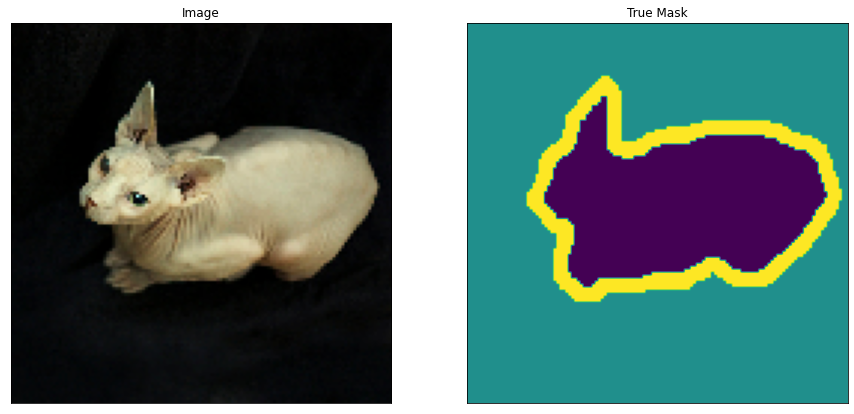

In [9]:
show_image_from_dataset(train_images)

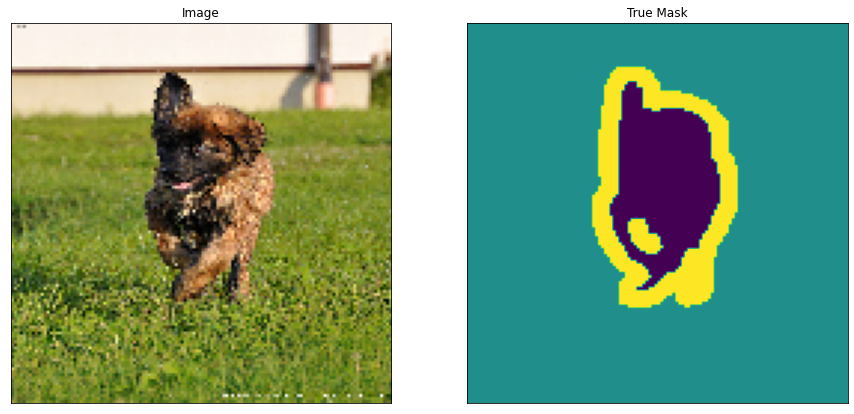

In [10]:
show_image_from_dataset(test_images)

## Unet :

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' > 


Unet has three parts :
- Encoder Block : It downsamples the image.
- Bottleneck .
- Decoder Block : It upsamples the image.

## Part 1 : Encoder.

In [11]:
def conv_block(input_tensor, num_filters, kernel_size=(3,3)):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(
            filters=num_filters, 
            activation = 'relu',
            kernel_size= kernel_size,
            kernel_initializer='he_normal', padding='same')(x)
        return x

In [12]:
def encoder_block(inputs, num_filters, pool_size=(2,2), dropout_rate=0.3):
    f = conv_block(inputs, num_filters=num_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(rate=dropout_rate)(p)
    return f, p

def encoder(inputs):
    f1, p1 = encoder_block(inputs=inputs, num_filters=64)
    f2, p2 = encoder_block(inputs=p1, num_filters=128)
    f3, p3 = encoder_block(inputs=p2, num_filters=256)
    f4, p4 = encoder_block(inputs=p3, num_filters=512)
    return p4, (f1, f2, f3, f4)

## Part 2 : Bottleneck.

In [13]:
def bottleneck(inputs):
    bottle_neck = conv_block(input_tensor=inputs, num_filters=1024)
    return bottle_neck 

## Part 3 : Decoder.

In [14]:
def decoder_block(inputs, conv_input, num_filters, kernel_size=(3,3), strides=(2,2), dropout_rate=0.3):
    u = tf.keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_input])
    c = tf.keras.layers.Dropout(dropout_rate)(c)
    c = conv_block(c, num_filters=num_filters, kernel_size=kernel_size)

    return c
def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4 = convs
    c6 = decoder_block(inputs=inputs, conv_input=f4, num_filters=512)
    c7 = decoder_block(inputs=c6, conv_input=f3, num_filters=256)
    c8 = decoder_block(inputs=c7, conv_input=f2, num_filters=128)
    c9 = decoder_block(inputs=c8, conv_input=f1, num_filters=64)
    outputs = tf.keras.layers.Conv2D(filters=output_channels, kernel_size=(1,1), activation='softmax')(c9)
    return outputs

## Combining Everything

In [15]:
def unet(output_channels=3):
    inputs = tf.keras.layers.Input(shape=(128, 128, 3, ))
    encoder_output, convs =  encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(inputs=bottle_neck, convs=convs, output_channels=output_channels)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
model = unet() 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 64)   0           max_pooling2d[0][0]              
______________________________________________________________________________________________

## Compile & Train the model.
#### loss function used : `sparse_categorical_crossentropy`. 
The reason is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class and `sparse_categorical_crossentropy` is the recommended loss for such a scenario. 

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

In [18]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\User\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    

In [19]:
train_length = info.splits['train'].num_examples
test_length = info.splits['test'].num_examples
epochs = 2 
val_subsplits = 5 
steps_per_epoch = train_length // batch_size
validation_steps_per_epoch = test_length // batch_size // val_subsplits

In [20]:
history = model.fit(
    x=train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset, 
    validation_steps=validation_steps_per_epoch)

Epoch 1/10
 1/57 [..............................] - ETA: 47:43 - loss: 1.4078 - accuracy: 0.2355